In [1]:
# 50,000 samples
# NEW new normalizations
# NOT normalizing the inputs
# normalizing outputs
# no more train_test_split
# trialing epochs
#trialing validations
# trial various activation functions

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import keras
import keras_metrics as km
import keras
from keras import metrics

gpu_num = 1

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2023-11-27 19:16:25.295953: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 19:16:25.339309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 19:16:26.072443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/braun2/anaconda3/envs/tf/lib/python3.8/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable local

2 Physical GPUs, 2 Logical GPUs
Visible devices cannot be modified after being initialized


2023-11-27 19:16:31.181021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46702 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2023-11-27 19:16:31.181538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46702 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [2]:
gamma0_real = np.loadtxt("eos_polytrope_gamma_0-50000.dat.txt", dtype=float)
gamma1_real = np.loadtxt("eos_polytrope_gamma_1-50000.dat.txt", dtype=float)
gamma2_real = np.loadtxt("eos_polytrope_gamma_2-50000.dat.txt", dtype=float)
l1_real = np.loadtxt('lambda_1-50000.dat.txt', dtype=float)
l2_real = np.loadtxt('lambda_2-50000.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1-50000.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2-50000.dat.txt", dtype=float)
m1_real = np.loadtxt("mass_1_source-50000.dat.txt", dtype=float)
m2_real = np.loadtxt("mass_2_source-50000.dat.txt", dtype=float)

In [3]:
len(m2_real)

50000

In [4]:
m1_dat = m1_real
m2_dat = m2_real
l1_dat = l1_real
l2_dat = l2_real

# Functions

In [5]:
#formatting array & processing outputs

def format_output(data):
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    logp1_si = data.pop('logp1_si')
    logp1_si = np.array(logp1_si)
    logp2_si = data.pop('logp2_si')
    logp2_si = np.array(logp2_si)
    return gamma0, gamma1, gamma2, logp1_si, logp2_si



In [6]:
#return inputs back to original values in order to plot EOS

# log(p1) & p2 ∈ [33, 37], in cgs
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]


# unnorm function 1
def unnorm(predictionsarray):
    
    for i in range (len(predictionsarray)):
        new_gamma0_array = predictionsarray[0] * (5 - 1) + 1
        new_gamma1_array = predictionsarray[1] * (5 - 1) + 1
        new_gamma2_array = predictionsarray[2] * (5 - 1) + 1
        
        #cgs
        cgs_logp1 = predictionsarray[3]
        cgs_logp2 = predictionsarray[4]
        
        #normalize in si
        si_logp1_unnorm = cgs_logp1 * ((37-1) - (33-1)) + (33-1) +1
        si_logp2_unnorm = cgs_logp2 * ((37-1) - (33-1)) + (33-1) +1
        
        
        #convert back to si
        #new_logp1_array = cgs_logp1_unnorm - 1
        #new_logp2_array = cgs_logp2_unnorm - 1
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, si_logp1_unnorm, si_logp2_unnorm), axis=1)

    return new_array



# unnorm function 2
def minmaxunnorm(predictionsarray):

    for i in range (len(predictionsarray)):
        
        gam0 = predictionsarray[0]
        gam1 = predictionsarray[1]
        gam2 = predictionsarray[2]
        
        gam0max = np.max(predictionsarray[0])
        gam0min = np.min(predictionsarray[0])
        
        gam1max = np.max(predictionsarray[1])
        gam1min = np.min(predictionsarray[1])
        
        gam2max = np.max(predictionsarray[2])
        gam2min = np.min(predictionsarray[2])
        
        new_gamma0_array = (5 - 1)*((gam0 - gam0min)/(gam0max-gam0min)) + 1
        new_gamma1_array = (5 - 1)*((gam1 - gam1min)/(gam1max-gam1min)) + 1
        new_gamma2_array = (5 - 1)*((gam2 - gam2min)/(gam2max-gam2min)) + 1

        
        
        si_logp1 = predictionsarray[3]
        si_logp2 = predictionsarray[4]
        
        logp1max = np.max(si_logp1)
        logp1min = np.min(si_logp1)
        
        logp2max = np.max(si_logp2)
        logp2min = np.min(si_logp2)
        
        #minmax normalization
        
        #range [a,b]
        #measured min: min
        #measured max: max
        #array = x
        
        # (b - a) ((x - min)/(max-min)) + a
        # [32, 36]
        
        new_logp1_array = (36 - 32)*((si_logp1 - logp1min)/(logp1max-logp1min)) + 32
        new_logp2_array = (36 - 32)*((si_logp2 - logp2min)/(logp2max-logp2min)) + 32
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_logp1_array, new_logp2_array), axis=1)

    return new_array


# MLA

In [7]:
#normalizing to be between 0 and 1!


# log(p1) & p2 ∈ [33, 37], in cgs
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]

#normalizing into si (using bounds 32 and 36)

logp1_s_norm = ((logp1_cgs - 1) - (33-1))/((37-1) - (33-1))
logp2_s_norm = ((logp2_cgs - 1) - (33-1))/((37-1) - (33-1))

logp1_si = logp1_s_norm
logp2_si = logp2_s_norm


sd_gamma0 = (gamma0_real - 1)/(5 - 1)
sd_gamma1 = (gamma1_real - 1)/(5 - 1)
sd_gamma2 = (gamma2_real - 1)/(5 - 1)


un-normalized outputs

1.0003192964114245
4.99999336785112


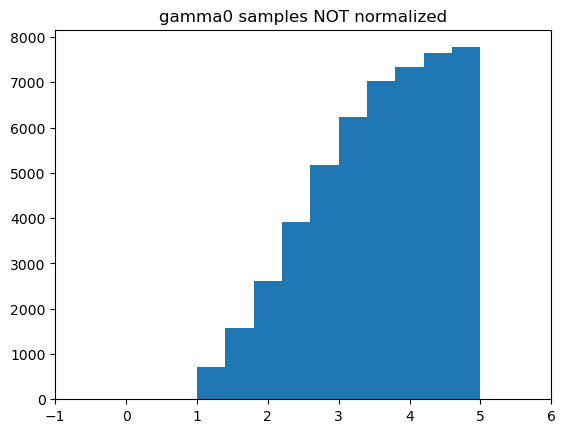

1.0004706315315508
4.999965359237742


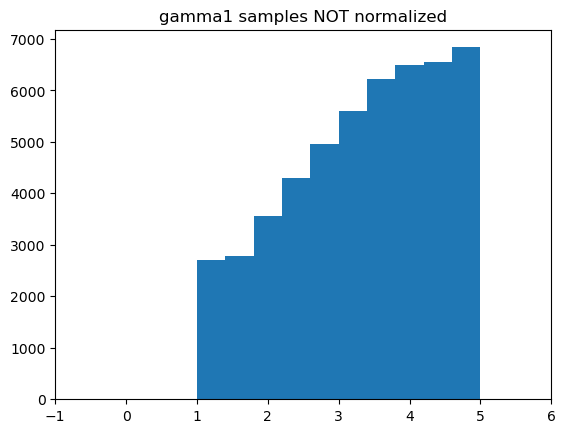

1.0000475384191239
4.012066979738811


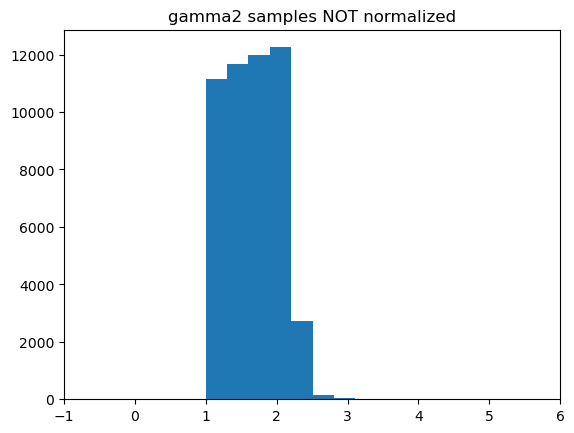

6.380354548696232e-06
0.9982374782488783


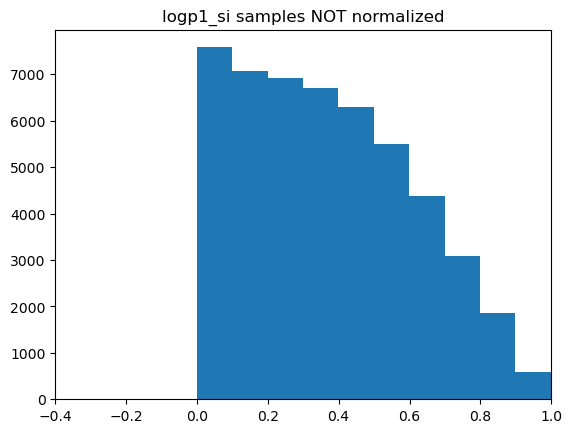

0.005309849258036792
0.9999909738448292


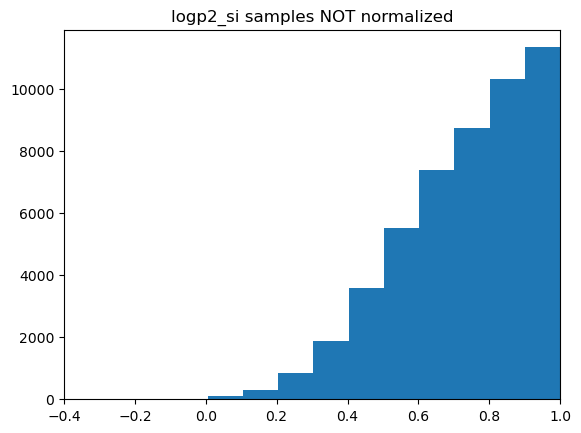

In [8]:
plt.hist(gamma0_real[0:50000])
plt.title("gamma0 samples NOT normalized")
print(np.min(gamma0_real))
print(np.max(gamma0_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(gamma1_real[0:50000])
plt.title("gamma1 samples NOT normalized")
print(np.min(gamma1_real))
print(np.max(gamma1_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(gamma2_real[0:50000])
plt.title("gamma2 samples NOT normalized")
print(np.min(gamma2_real))
print(np.max(gamma2_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(logp1_s_norm[0:50000])
plt.title("logp1_si samples NOT normalized")
print(np.min(logp1_si))
print(np.max(logp1_si))
plt.xlim(-.4, 1)
plt.show()

plt.hist(logp2_s_norm[0:50000])
plt.title("logp2_si samples NOT normalized")
print(np.min(logp2_si))
print(np.max(logp2_si))
plt.xlim(-.4, 1)
plt.show()

normalized outputs

7.982410285611863e-05
0.99999834196278


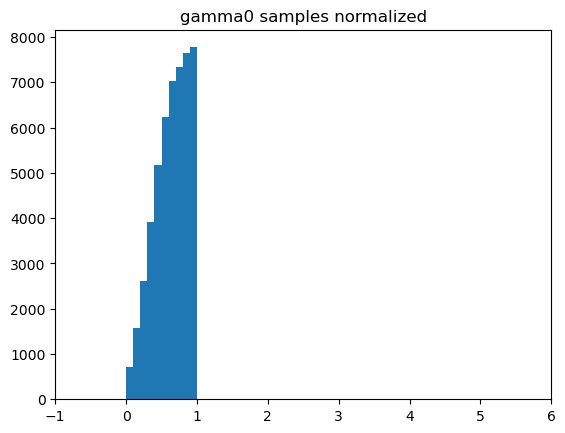

0.00011765788288770063
0.9999913398094356


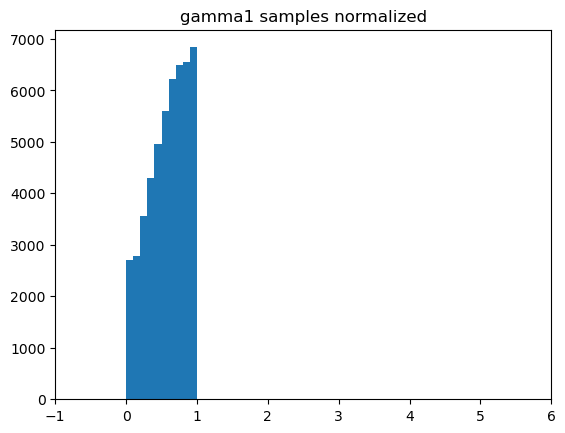

1.1884604780965091e-05
0.7530167449347027


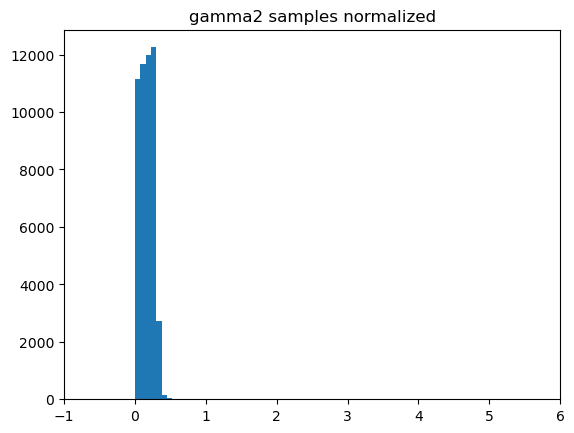

6.380354548696232e-06
0.9982374782488783


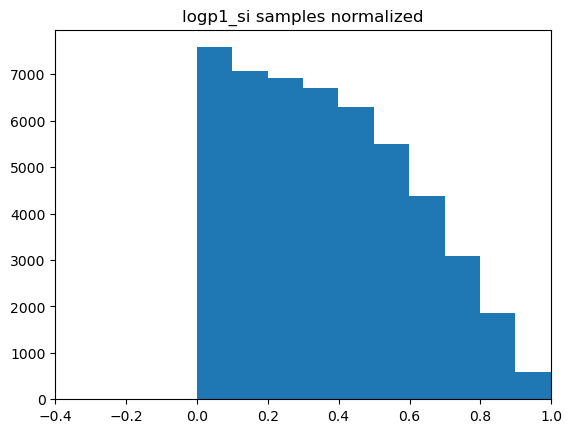

0.005309849258036792
0.9999909738448292


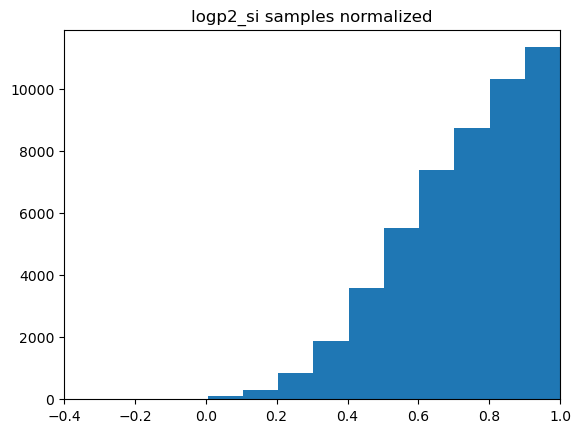

In [9]:
plt.hist(sd_gamma0[0:50000])
plt.title("gamma0 samples normalized")
print(np.min(sd_gamma0))
print(np.max(sd_gamma0))
plt.xlim(-1, 6)
plt.show()

plt.hist(sd_gamma1[0:50000])
plt.title("gamma1 samples normalized")
print(np.min(sd_gamma1))
print(np.max(sd_gamma1))
plt.xlim(-1, 6)
plt.show()

plt.hist(sd_gamma2[0:50000])
plt.title("gamma2 samples normalized")
print(np.min(sd_gamma2))
print(np.max(sd_gamma2))
plt.xlim(-1, 6)
plt.show()

plt.hist(logp1_si[0:50000])
plt.title("logp1_si samples normalized")
print(np.min(logp1_si))
print(np.max(logp1_si))
plt.xlim(-.4, 1)
plt.show()

plt.hist(logp2_si[0:50000])
plt.title("logp2_si samples normalized")
print(np.min(logp2_si))
print(np.max(logp2_si))
plt.xlim(-.4, 1)
plt.show()

In [13]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 9 ] * len(sd_gamma0))
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(50000, 9)


In [14]:
#reformat data files into this new array
for i in range(0,len(m1_dat)-1):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = logp1_si[i]
    combined_array[i][8] = logp2_si[i]
    

In [15]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'logp1_si', 'logp2_si']
print(data)

             m1        m2            l1            l2    gamma0    gamma1  \
0      1.704363  0.940013     48.538860     48.538860  0.437453  0.790931   
1      0.674195  0.488352  42688.433302  42688.433302  0.648856  0.745487   
2      1.944506  1.625537    167.805410    167.805410  0.630087  0.988135   
3      0.582582  0.362044  48488.884176  48488.884176  0.479282  0.037464   
4      2.684166  2.462512     51.173074     51.173074  0.813159  0.580368   
...         ...       ...           ...           ...       ...       ...   
49995  1.093111  0.866491   6448.234563   6448.234563  0.697939  0.943270   
49996  0.450100  0.421913  79178.345326  79178.345326  0.340501  0.444478   
49997  1.229125  0.916376   3175.028837   3175.028837  0.573449  0.782659   
49998  0.884386  0.667397  19935.240905  19935.240905  0.899699  0.701662   
49999  0.000000  0.000000      0.000000      0.000000  0.000000  0.000000   

         gamma2  logp1_si  logp2_si  
0      0.034513  0.591370  0.691493  

In [19]:
# 541 total samples: 80% = 432, 20% = 108.2
# for train and test ONLY:
# we want the first 432 samples to = train
# we want the last 109 samples to = test
# split row-wise, not collumn-wise

# splitting dataframe by row index
train = data.iloc[:int(len(m2_real)*.8),:]
test = data.iloc[int(len(m2_real)*.8):,:]
print("Shape of new dataframes - {} , {}".format(train.shape, test.shape))

train_stats = train.describe()

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()


train_Y = format_output(train)
test_Y = format_output(test)


Shape of new dataframes - (40000, 9) , (10000, 9)


In [20]:
print(train_Y)

(array([0.39531543, 0.3281356 , 0.93480321, ..., 0.55202612, 0.82853198,
       0.94239945]), array([0.6710705 , 0.68074642, 0.40385271, ..., 0.21200365, 0.77778669,
       0.0221251 ]), array([0.26397589, 0.11806614, 0.1939362 , ..., 0.1207382 , 0.15631094,
       0.45189556]), array([0.07092826, 0.22120889, 0.49350701, ..., 0.67600355, 0.06708263,
       0.34331563]), array([0.86796005, 0.85943872, 0.57036025, ..., 0.84270232, 0.83304644,
       0.86581623]))


In [18]:
#split data into train and test

data = data.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(data, test_size=0.2)

print(train)

train_stats = train.describe()

#get gamma as the outputs and format them as np arrays.

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

             m1        m2             l1             l2    gamma0    gamma1  \
10743  0.543538  0.487225  121222.785253  121222.785253  0.674140  0.995349   
32714  2.796953  2.180302      59.960298      59.960298  0.972743  0.554012   
17980  0.960022  0.314883    6046.754214    6046.754214  0.561144  0.494420   
8612   0.656665  0.448432   54799.282397   54799.282397  0.712375  0.609794   
26201  2.749541  1.884661      25.121276      25.121276  0.721235  0.737863   
...         ...       ...            ...            ...       ...       ...   
21493  1.900227  0.956882     215.684485     215.684485  0.647210  0.037634   
21121  2.611682  1.662655      59.054799      59.054799  0.797542  0.887784   
49884  1.460524  1.422631      28.969362      28.969362  0.370190  0.893326   
10212  0.821619  0.466287     386.169418     386.169418  0.289354  0.071656   
43694  0.861659  0.582399   23384.889078   23384.889078  0.939250  0.982290   

         gamma2  logp1_si  logp2_si  
10743  0.1033

In [15]:
norm_train_X = train
norm_test_X = test

In [16]:
input_layer = Input(shape=(len(train .columns),))

layeract = 'tanh'
outputact = 'sigmoid'

first_dense = Dense(units='128', activation=layeract)(input_layer)
second_dense = Dense(units='128', activation=layeract)(first_dense)
third_dense = Dense(units='128', activation=layeract)(second_dense)
fourth_dense = Dense(units='128', activation=layeract)(third_dense)
fifth_dense = Dense(units='128', activation=layeract)(fourth_dense)
sixth_dense = Dense(units='128', activation=layeract)(fifth_dense)
seventh_dense = Dense(units='128', activation=layeract)(sixth_dense)
eight_dense = Dense(units='128', activation=layeract)(seventh_dense)
ninth_dense = Dense(units='128', activation=layeract)(eight_dense)
    
tenth_dense = Dense(units='128', activation=layeract)(ninth_dense)
eleventh_dense = Dense(units='128', activation=layeract)(tenth_dense)
twelth_dense = Dense(units='128', activation=layeract)(eleventh_dense)
thirteenth_dense = Dense(units='128', activation=layeract)(twelth_dense)
fourteenth_dense = Dense(units='128', activation=layeract)(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation=layeract)(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation=layeract)(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation=layeract)(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation=layeract)(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation=layeract)(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation=layeract)(nineteenth_dense)
tf_dense = Dense(units='128', activation=layeract)(twentieth_dense)
ts_dense = Dense(units='128', activation=layeract)(tf_dense)
tt_dense = Dense(units='128', activation=layeract)(ts_dense)
tfo_dense = Dense(units='128', activation=layeract)(tt_dense)
tfi_dense = Dense(units='128', activation=layeract)(tfo_dense)
ts_dense = Dense(units='128', activation=layeract)(tfi_dense)
tse_dense = Dense(units='128', activation=layeract)(ts_dense)
te_dense = Dense(units='128', activation=layeract)(tse_dense)
tn_dense = Dense(units='128', activation=layeract)(te_dense)


gamma0_output = Dense(units='1', activation=outputact, name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation=layeract)(tn_dense)

ths_dense = Dense(units='128', activation=layeract)(thf_dense)
tht_dense = Dense(units='128', activation=layeract)(ths_dense)
thfo_dense = Dense(units='128', activation=layeract)(tht_dense)
thfi_dense = Dense(units='128', activation=layeract)(thfo_dense)
ths_dense = Dense(units='128', activation=layeract)(thfi_dense)
thse_dense = Dense(units='128', activation=layeract)(ths_dense)
the_dense = Dense(units='128', activation=layeract)(thse_dense)
thn_dense = Dense(units='128', activation=layeract)(the_dense)

gamma1_output = Dense(units='1', activation=outputact, name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation=layeract)(thn_dense)

fof_dense = Dense(units='128', activation=layeract)(fo_dense)
fos_dense = Dense(units='128', activation=layeract)(fof_dense)
fot_dense = Dense(units='128', activation=layeract)(fos_dense)
fofo_dense = Dense(units='128', activation=layeract)(fot_dense)
fofi_dense = Dense(units='128', activation=layeract)(fofo_dense)

gamma2_output = Dense(units='1', activation=outputact, name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation=layeract)(fofi_dense)

fose_dense = Dense(units='128', activation=layeract)(fos_dense)
foe_dense = Dense(units='128', activation=layeract)(fose_dense)
fon_dense = Dense(units='128', activation=layeract)(foe_dense)
fif_dense = Dense(units='128', activation=layeract)(fon_dense)

logp1_si_output = Dense(units='1', activation=outputact, name='logp1_si_output')(fon_dense)

fiff_dense = Dense(units='128', activation=layeract)(fon_dense)
fifs_dense = Dense(units='128', activation=layeract)(fiff_dense)
fift_dense = Dense(units='128', activation=layeract)(fifs_dense)
fiff_dense = Dense(units='128', activation=layeract)(fift_dense)
fiffi_dense = Dense(units='128', activation=layeract)(fiff_dense)
fifs_dense = Dense(units='128', activation=layeract)(fiffi_dense)

logp2_si_output = Dense(units='1', activation=outputact, name='logp2_si_output')(fifs_dense)


model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, logp1_si_output, logp2_si_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  640       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 128)                  16512     ['dense_1[0][0]']             
                                                                                              

 dense_39 (Dense)            (None, 128)                  4224      ['dense_38[0][0]']            
                                                                                                  
 dense_40 (Dense)            (None, 128)                  16512     ['dense_39[0][0]']            
                                                                                                  
 dense_41 (Dense)            (None, 128)                  16512     ['dense_40[0][0]']            
                                                                                                  
 dense_42 (Dense)            (None, 128)                  16512     ['dense_41[0][0]']            
                                                                                                  
 dense_43 (Dense)            (None, 128)                  16512     ['dense_42[0][0]']            
                                                                                                  
 dense_44 

In [17]:
#plot_model(model, to_file='DynamicPolytropeMLA.png', show_shapes=True, show_layer_names=True)

In [18]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'logp1_si_output': 'mse', 'logp2_si_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'logp1_si_output': tf.keras.metrics.MeanSquaredError(),
                       'logp2_si_output': tf.keras.metrics.MeanSquaredError()
                      })

endmetric = "mean_squared_error"

In [20]:
#train the model for a number of epochs

numepochs = 300
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=50,mode='auto')])


Epoch 1/300
3200/3200 [==============================] - 26s 8ms/step - loss: 0.2260 - gamma0_output_loss: 0.0499 - gamma1_output_loss: 0.0725 - gamma2_output_loss: 0.0093 - logp1_si_output_loss: 0.0576 - logp2_si_output_loss: 0.0366 - gamma0_output_mean_squared_error: 0.0499 - gamma1_output_mean_squared_error: 0.0725 - gamma2_output_mean_squared_error: 0.0093 - logp1_si_output_mean_squared_error: 0.0576 - logp2_si_output_mean_squared_error: 0.0366 - val_loss: 0.2097 - val_gamma0_output_loss: 0.0378 - val_gamma1_output_loss: 0.0717 - val_gamma2_output_loss: 0.0092 - val_logp1_si_output_loss: 0.0559 - val_logp2_si_output_loss: 0.0351 - val_gamma0_output_mean_squared_error: 0.0378 - val_gamma1_output_mean_squared_error: 0.0717 - val_gamma2_output_mean_squared_error: 0.0092 - val_logp1_si_output_mean_squared_error: 0.0559 - val_logp2_si_output_mean_squared_error: 0.0351
Epoch 2/300
3200/3200 [==============================] - 26s 8ms/step - loss: 0.2185 - gamma0_output_loss: 0.0443 - gamm

3200/3200 [==============================] - 26s 8ms/step - loss: 0.2123 - gamma0_output_loss: 0.0393 - gamma1_output_loss: 0.0719 - gamma2_output_loss: 0.0089 - logp1_si_output_loss: 0.0564 - logp2_si_output_loss: 0.0358 - gamma0_output_mean_squared_error: 0.0393 - gamma1_output_mean_squared_error: 0.0719 - gamma2_output_mean_squared_error: 0.0089 - logp1_si_output_mean_squared_error: 0.0564 - logp2_si_output_mean_squared_error: 0.0358 - val_loss: 0.2086 - val_gamma0_output_loss: 0.0368 - val_gamma1_output_loss: 0.0719 - val_gamma2_output_loss: 0.0091 - val_logp1_si_output_loss: 0.0559 - val_logp2_si_output_loss: 0.0349 - val_gamma0_output_mean_squared_error: 0.0368 - val_gamma1_output_mean_squared_error: 0.0719 - val_gamma2_output_mean_squared_error: 0.0091 - val_logp1_si_output_mean_squared_error: 0.0559 - val_logp2_si_output_mean_squared_error: 0.0349
Epoch 20/300
3200/3200 [==============================] - 26s 8ms/step - loss: 0.2114 - gamma0_output_loss: 0.0386 - gamma1_output_l

3200/3200 [==============================] - 26s 8ms/step - loss: 0.2099 - gamma0_output_loss: 0.0375 - gamma1_output_loss: 0.0715 - gamma2_output_loss: 0.0089 - logp1_si_output_loss: 0.0562 - logp2_si_output_loss: 0.0356 - gamma0_output_mean_squared_error: 0.0375 - gamma1_output_mean_squared_error: 0.0715 - gamma2_output_mean_squared_error: 0.0089 - logp1_si_output_mean_squared_error: 0.0562 - logp2_si_output_mean_squared_error: 0.0356 - val_loss: 0.2093 - val_gamma0_output_loss: 0.0380 - val_gamma1_output_loss: 0.0715 - val_gamma2_output_loss: 0.0089 - val_logp1_si_output_loss: 0.0561 - val_logp2_si_output_loss: 0.0348 - val_gamma0_output_mean_squared_error: 0.0380 - val_gamma1_output_mean_squared_error: 0.0715 - val_gamma2_output_mean_squared_error: 0.0089 - val_logp1_si_output_mean_squared_error: 0.0561 - val_logp2_si_output_mean_squared_error: 0.0348
Epoch 38/300
3200/3200 [==============================] - 26s 8ms/step - loss: 0.2100 - gamma0_output_loss: 0.0376 - gamma1_output_l

3200/3200 [==============================] - 26s 8ms/step - loss: 0.2080 - gamma0_output_loss: 0.0360 - gamma1_output_loss: 0.0715 - gamma2_output_loss: 0.0089 - logp1_si_output_loss: 0.0561 - logp2_si_output_loss: 0.0355 - gamma0_output_mean_squared_error: 0.0360 - gamma1_output_mean_squared_error: 0.0715 - gamma2_output_mean_squared_error: 0.0089 - logp1_si_output_mean_squared_error: 0.0561 - logp2_si_output_mean_squared_error: 0.0355 - val_loss: 0.2120 - val_gamma0_output_loss: 0.0411 - val_gamma1_output_loss: 0.0716 - val_gamma2_output_loss: 0.0089 - val_logp1_si_output_loss: 0.0557 - val_logp2_si_output_loss: 0.0346 - val_gamma0_output_mean_squared_error: 0.0411 - val_gamma1_output_mean_squared_error: 0.0716 - val_gamma2_output_mean_squared_error: 0.0089 - val_logp1_si_output_mean_squared_error: 0.0557 - val_logp2_si_output_mean_squared_error: 0.0346
Epoch 56/300
3200/3200 [==============================] - 26s 8ms/step - loss: 0.2082 - gamma0_output_loss: 0.0362 - gamma1_output_l

3200/3200 [==============================] - 26s 8ms/step - loss: 0.2076 - gamma0_output_loss: 0.0357 - gamma1_output_loss: 0.0714 - gamma2_output_loss: 0.0089 - logp1_si_output_loss: 0.0560 - logp2_si_output_loss: 0.0355 - gamma0_output_mean_squared_error: 0.0357 - gamma1_output_mean_squared_error: 0.0714 - gamma2_output_mean_squared_error: 0.0089 - logp1_si_output_mean_squared_error: 0.0560 - logp2_si_output_mean_squared_error: 0.0355 - val_loss: 0.2030 - val_gamma0_output_loss: 0.0327 - val_gamma1_output_loss: 0.0715 - val_gamma2_output_loss: 0.0089 - val_logp1_si_output_loss: 0.0554 - val_logp2_si_output_loss: 0.0346 - val_gamma0_output_mean_squared_error: 0.0327 - val_gamma1_output_mean_squared_error: 0.0715 - val_gamma2_output_mean_squared_error: 0.0089 - val_logp1_si_output_mean_squared_error: 0.0554 - val_logp2_si_output_mean_squared_error: 0.0346
Epoch 74/300
3200/3200 [==============================] - 26s 8ms/step - loss: 0.2070 - gamma0_output_loss: 0.0352 - gamma1_output_l

In [21]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, logp1_si_loss, logp1_si_accuracy, logp2_si_loss, logp2_si_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)


313/313 [==============================] - 1s 3ms/step - loss: 0.2030 - gamma0_output_loss: 0.0331 - gamma1_output_loss: 0.0721 - gamma2_output_loss: 0.0089 - logp1_si_output_loss: 0.0546 - logp2_si_output_loss: 0.0342 - gamma0_output_mean_squared_error: 0.0331 - gamma1_output_mean_squared_error: 0.0721 - gamma2_output_mean_squared_error: 0.0089 - logp1_si_output_mean_squared_error: 0.0546 - logp2_si_output_mean_squared_error: 0.0342


In [22]:
new_predictions = model.predict(norm_train_X.to_numpy())
predictions = unnorm(new_predictions)
#predictions = minmaxunnorm(new_predictions)

1250/1250 [==============================] - 3s 2ms/step


In [23]:
len(predictions)

40000

In [24]:
print(predictions)

[[ 3.323562   3.2724586  1.6698799 34.349712  35.79103  ]
 [ 3.9946854  3.3898962  1.6447961 34.544224  35.8794   ]
 [ 3.3173146  3.2761354  1.6697953 34.3494    35.79255  ]
 ...
 [ 3.809649   3.6752548  1.6330998 34.48867   36.125885 ]
 [ 4.5793896  3.3387032  1.6588299 34.81326   35.944366 ]
 [ 3.1825104  3.5198443  1.6544986 34.364197  36.018253 ]]


normalized outputs histogram

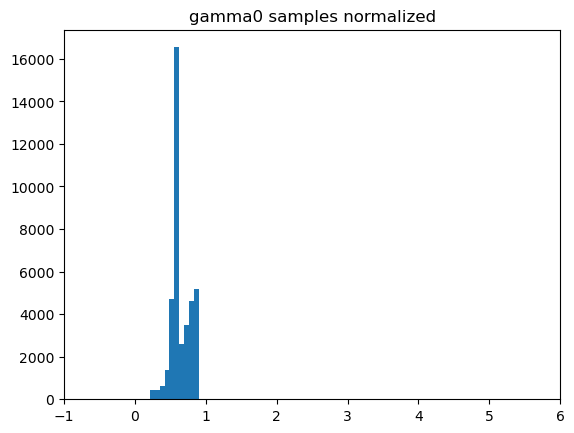

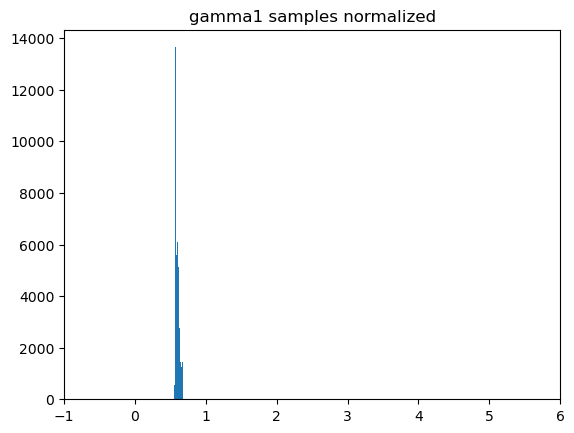

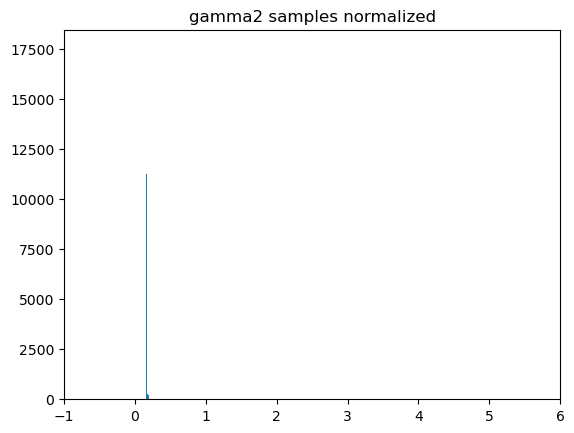

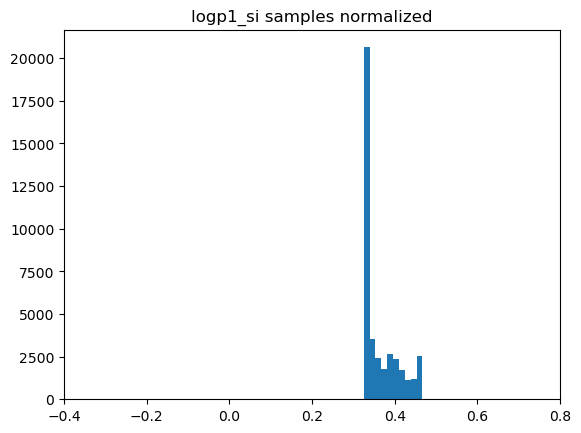

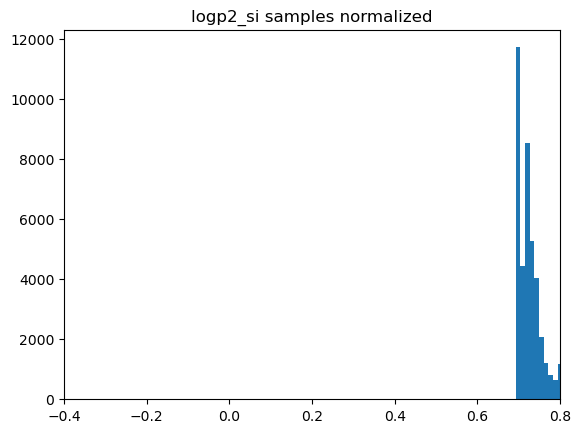

In [25]:
plt.hist(new_predictions[0])
plt.title("gamma0 samples normalized")
#print(np.min(new_predictions[0]))
#print(np.max(new_predictions[0]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[1])
plt.title("gamma1 samples normalized")
#print(np.min(new_predictions[1]))
#print(np.max(new_predictions[1]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[2])
plt.title("gamma2 samples normalized")
#print(np.min(new_predictions[2]))
#print(np.max(new_predictions[2]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[3])
plt.title("logp1_si samples normalized")
#print(np.min(new_predictions[3]))
#print(np.max(new_predictions[3]))
plt.xlim(-.4, .8)
plt.show()

plt.hist(new_predictions[4])
plt.title("logp2_si samples normalized")
#print(np.min(new_predictions[4]))
#print(np.max(new_predictions[4]))
plt.xlim(-.4, .8)
plt.show()

un-normalized outputs histogram

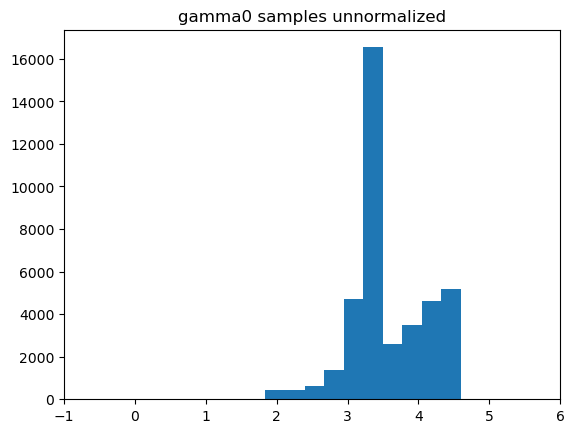

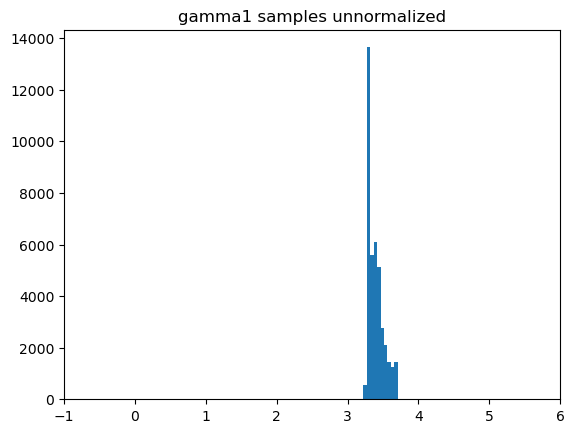

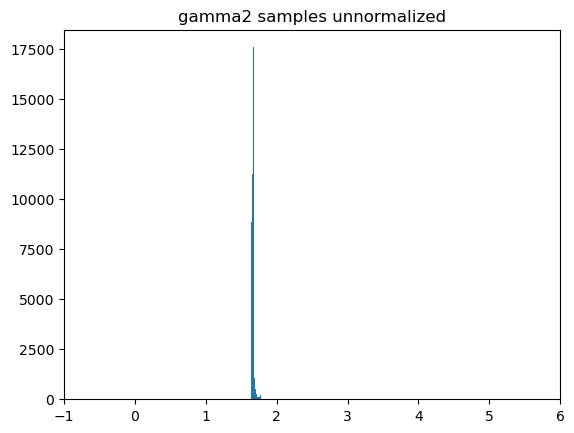

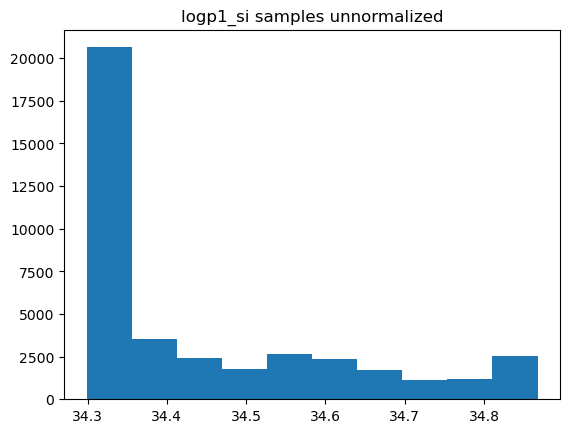

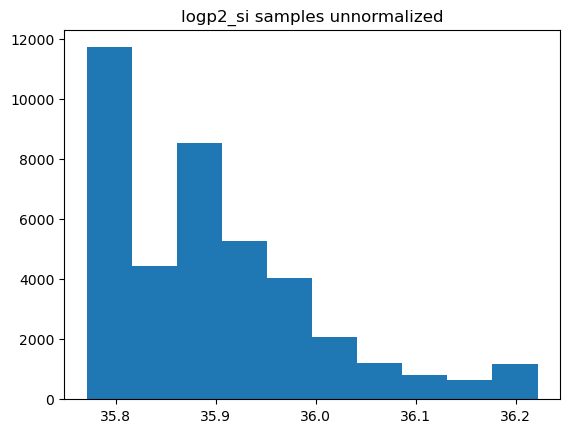

In [26]:
normgam0ar = []
for i in range (40000):
    normgam0ar.append(predictions[i][0])
plt.hist(normgam0ar)
plt.title("gamma0 samples unnormalized")
plt.xlim(-1, 6)
plt.show()


normgam1ar = []
for i in range (40000):
    normgam1ar.append(predictions[i][1])
plt.hist(normgam1ar)
plt.title("gamma1 samples unnormalized")
plt.xlim(-1, 6)
plt.show()


normgam2ar = []
for i in range (40000):
    normgam2ar.append(predictions[i][2])
plt.hist(normgam2ar)
plt.title("gamma2 samples unnormalized")
#print(np.min(new_predictions[2]))
#print(np.max(new_predictions[2]))
plt.xlim(-1, 6)
plt.show()


normlogp1ar = []
for i in range (40000):
    normlogp1ar.append(predictions[i][3])
plt.hist(normlogp1ar)
plt.title("logp1_si samples unnormalized")
#print(np.min(new_predictions[3]))
#print(np.max(new_predictions[3]))
#plt.xlim(-.4, .8)
plt.show()


normlogp2ar = []
for i in range (40000):
    normlogp2ar.append(predictions[i][4])
plt.hist(normlogp2ar)
plt.title("logp2_si samples unnormalized")
#print(np.min(new_predictions[4]))
#print(np.max(new_predictions[4]))
#plt.xlim(-.4, .8)
plt.show()

# Plot one EOS

In [27]:

# log(p1) & p2 ∈ [33, 37], in cgs
# [32, 36] in si
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]

fgam0 = float(predictions[0][0])
print(fgam0)
fgam1 = float(predictions[0][1])
print(fgam1)
fgam2 = float(predictions[0][2])
print(fgam2)
flogp1 = float(predictions[0][3])
print(flogp1)
flogp2 = float(predictions[0][4]) 
print(flogp2)

3.323561906814575
3.272458553314209
1.6698799133300781
34.34971237182617
35.79103088378906


In [28]:
oneEOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(fgam0, flogp1, fgam1, flogp2, fgam2)

In [29]:
act_hmin = 0.01
act_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(oneEOS)

act_loghmin = np.log10(act_hmin)
act_loghmax = np.log10(act_hmax)

act_h_array = np.linspace(act_loghmin,act_loghmax,1000)

act_density = []
act_pressure = []

for h in act_h_array:
    act_density.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(10**h,oneEOS))
    act_pressure.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(10**h,oneEOS))
    
    
act_density = np.array(act_density)
act_pressure = np.array(act_pressure)

#cgs units
act_density_cgs = act_density * 1e-3
act_pressure_cgs = act_pressure * 10

act_logdensity = np.log10(act_density_cgs)
act_logpressure = np.log10(act_pressure_cgs)

Text(0, 0.5, 'pressure')

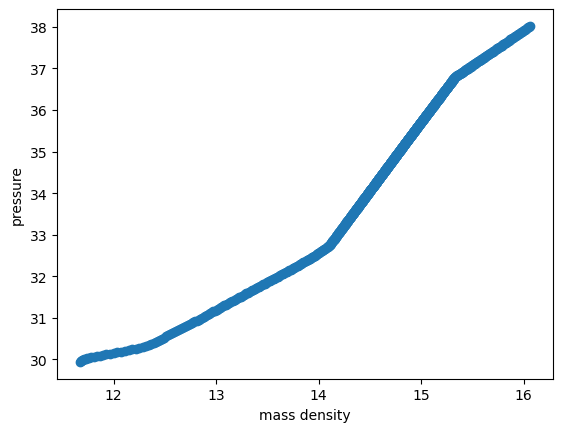

In [30]:
plt.plot(act_logdensity,act_logpressure,marker = 'o')
plt.xlabel("mass density")
plt.ylabel("pressure")
#plt.xlim([14,15.4])
#plt.ylim([32,37])

# EOS


In [31]:
#length = len(predictions)
length = 40000

Progress : 0 / 40000, 0.00%
Progress : 1000 / 40000, 2.50%
Progress : 2000 / 40000, 5.00%
Progress : 3000 / 40000, 7.50%
Progress : 4000 / 40000, 10.00%
Progress : 5000 / 40000, 12.50%
Progress : 6000 / 40000, 15.00%
Progress : 7000 / 40000, 17.50%
Progress : 8000 / 40000, 20.00%
Progress : 9000 / 40000, 22.50%
Progress : 10000 / 40000, 25.00%
Progress : 11000 / 40000, 27.50%
Progress : 12000 / 40000, 30.00%
Progress : 13000 / 40000, 32.50%
Progress : 14000 / 40000, 35.00%
Progress : 15000 / 40000, 37.50%
Progress : 16000 / 40000, 40.00%
Progress : 17000 / 40000, 42.50%
Progress : 18000 / 40000, 45.00%
Progress : 19000 / 40000, 47.50%
Progress : 20000 / 40000, 50.00%
Progress : 21000 / 40000, 52.50%
Progress : 22000 / 40000, 55.00%
Progress : 23000 / 40000, 57.50%
Progress : 24000 / 40000, 60.00%
Progress : 25000 / 40000, 62.50%
Progress : 26000 / 40000, 65.00%
Progress : 27000 / 40000, 67.50%
Progress : 28000 / 40000, 70.00%
Progress : 29000 / 40000, 72.50%
Progress : 30000 / 40000, 7

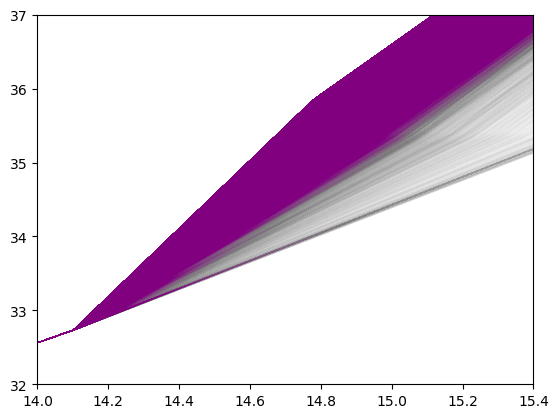

0


In [37]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
bad = 0
for i in range(length):
    try: 
        g0 = float(predictions[i][0])
        g1 = float(predictions[i][1])
        g2 = float(predictions[i][2])
        p1 = float(predictions[i][3])
        p2 = float(predictions[i][4])

        if i%1000==0:
            print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
        pdat = []
        rdat = []
        #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
        eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
        hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
        hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
        hdat = np.concatenate([hlow,hhigh])
        for h in hdat:
            pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
            rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
        #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
        plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.005)
        
    except:
        print("failed")
        bad += 1
        
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()
print(bad)

# Actual Values EOS

In [50]:
gamma0 = np.loadtxt("eos_polytrope_gamma_0.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2.dat.txt", dtype=float)
l1 = np.loadtxt('lambda_1.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2.dat.txt", dtype=float)
m1 = np.loadtxt("mass_1_source.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source.dat.txt", dtype=float)

logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

#length = len(gamma0)
length = 40000

Progress : 0 / 500, 0.00%
Progress : 10 / 500, 2.00%
Progress : 20 / 500, 4.00%
Progress : 30 / 500, 6.00%
Progress : 40 / 500, 8.00%
Progress : 50 / 500, 10.00%
Progress : 60 / 500, 12.00%
Progress : 70 / 500, 14.00%
Progress : 80 / 500, 16.00%
Progress : 90 / 500, 18.00%
Progress : 100 / 500, 20.00%
Progress : 110 / 500, 22.00%
Progress : 120 / 500, 24.00%
Progress : 130 / 500, 26.00%
Progress : 140 / 500, 28.00%
Progress : 150 / 500, 30.00%
Progress : 160 / 500, 32.00%
Progress : 170 / 500, 34.00%
Progress : 180 / 500, 36.00%
Progress : 190 / 500, 38.00%
Progress : 200 / 500, 40.00%
Progress : 210 / 500, 42.00%
Progress : 220 / 500, 44.00%
Progress : 230 / 500, 46.00%
Progress : 240 / 500, 48.00%
Progress : 250 / 500, 50.00%
Progress : 260 / 500, 52.00%
Progress : 270 / 500, 54.00%
Progress : 280 / 500, 56.00%
Progress : 290 / 500, 58.00%
Progress : 300 / 500, 60.00%
Progress : 310 / 500, 62.00%
Progress : 320 / 500, 64.00%
Progress : 330 / 500, 66.00%
Progress : 340 / 500, 68.00%
P

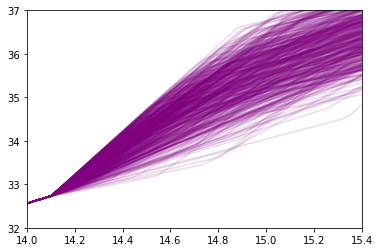

In [51]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    g0 = float(gamma0[i])
    g1 = float(gamma1[i])
    g2 = float(gamma2[i])
    p1 = float(logp1_s[i])
    p2 = float(logp2_s[i])
    
    if i%10==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
    eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.15)
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Loss

In [33]:
history.history.keys() 

dict_keys(['loss', 'gamma0_output_loss', 'gamma1_output_loss', 'gamma2_output_loss', 'logp1_si_output_loss', 'logp2_si_output_loss', 'gamma0_output_mean_squared_error', 'gamma1_output_mean_squared_error', 'gamma2_output_mean_squared_error', 'logp1_si_output_mean_squared_error', 'logp2_si_output_mean_squared_error', 'val_loss', 'val_gamma0_output_loss', 'val_gamma1_output_loss', 'val_gamma2_output_loss', 'val_logp1_si_output_loss', 'val_logp2_si_output_loss', 'val_gamma0_output_mean_squared_error', 'val_gamma1_output_mean_squared_error', 'val_gamma2_output_mean_squared_error', 'val_logp1_si_output_mean_squared_error', 'val_logp2_si_output_mean_squared_error'])

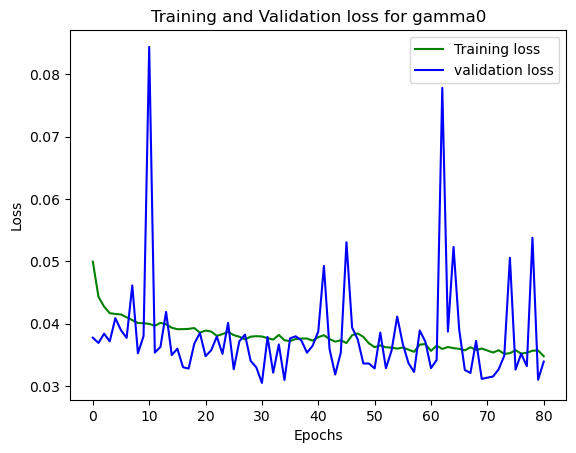

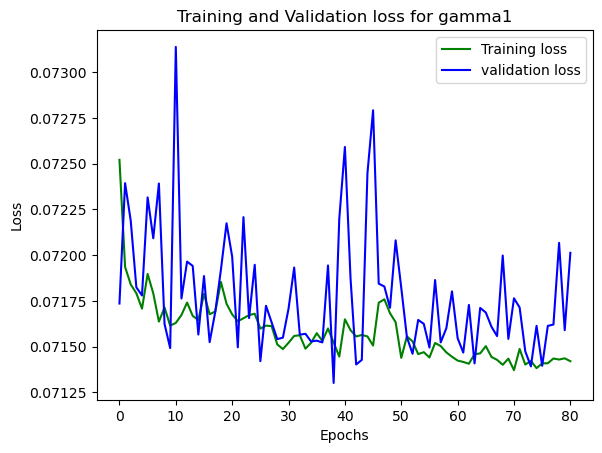

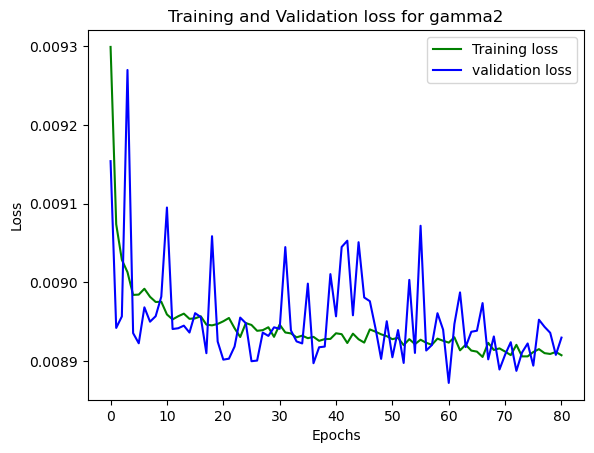

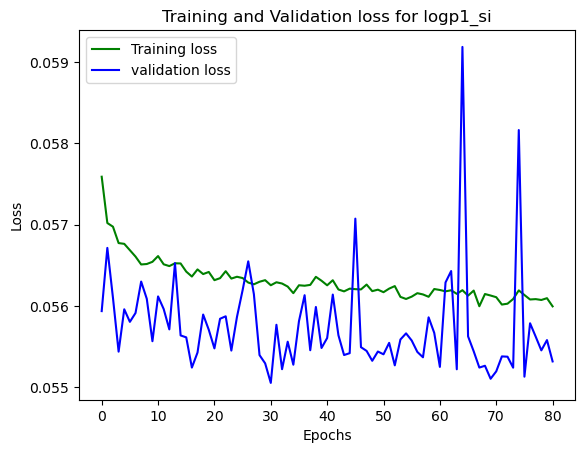

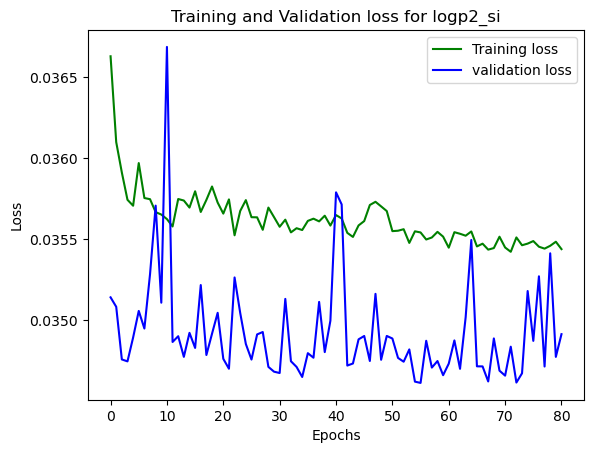

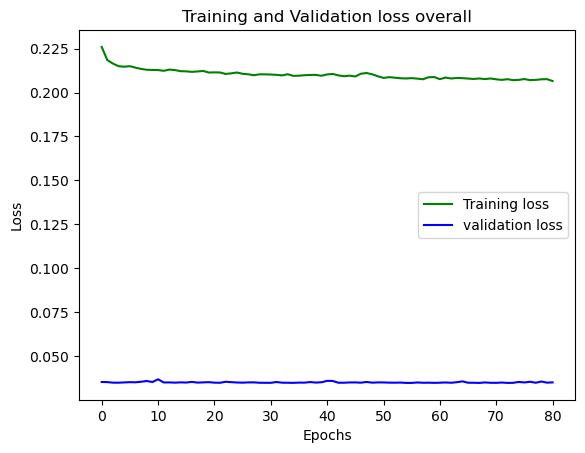

In [36]:
numepochs = 81
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for logp1_si values
loss_train = history.history['logp1_si_output_loss']
loss_val = history.history['val_logp1_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp1_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#loss for logp2_si values
loss_train = history.history['logp2_si_output_loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp2_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#overall loss
loss_train = history.history['loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss overall')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()